In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


In [2]:

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
df=pd.concat([pd.DataFrame(data),pd.DataFrame(target,columns=['score'])],axis=1)
display(df.head(2))

,0,1,2,3,4,5,6,7,8,9,10,11,12,score
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6


In [4]:
X = df.drop('score', axis=1)
y = df["score"]

In [18]:

numerical_cols =X.select_dtypes(include=np.number).columns
numerical_cols_=numerical_cols.astype(str)
categorical_cols = X.columns[X.dtypes == 'object']

print(f"We have {len(numerical_cols)} numeric columns: {', '.join(numerical_cols_)}")
print(f"And {len(categorical_cols)} categorical columns: {', '.join(categorical_cols)}")

We have 13 numeric columns: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
And 0 categorical columns: 


In [19]:
categorical_pipeline = Pipeline([
    ('encoder', OrdinalEncoder( ))
])

numerical_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.2)
X_train = preprocessors.fit_transform(X_train)
X_test = preprocessors.transform(X_test)

In [41]:
def plot_predict(y_test,predicted):
  A = np.array(y_test).reshape(-1, 1)
  B = predicted.reshape(-1, 1)

  print(type(predicted))
  print(type(y_test))
  plt.rcParams['figure.figsize'] = 10,5
  plt.figure()
  plt.plot(A[-100:], label="Real")
  plt.plot(B[-100:], label="Predicted")
  plt.legend()
  plt.title("score: real vs predicted")
  plt.ylabel("score")
  plt.xticks(())
  rmse = np.sqrt(mean_squared_error(y_test, predicted))

  print('RMSE: ',rmse)

  print('Variance score: %.2f' % r2_score(y_test, predicted))
  plt.show()

In [24]:
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer, mean_squared_error

scoring_function = make_scorer(mean_squared_error, greater_is_better=False)

class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LinearRegression()):
        """
        A Custom BaseEstimator that can switch between models.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)
   # def predict_proba(self, X):
       # return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

pipeline = Pipeline(steps=[
    ('model',  ClfSwitcher())
])

In [25]:

parameters_Lasso_Ridge = [
    {
        'model': ( LinearRegression(),)
    },
    {
        'model': ( Lasso(),),
        'model__alpha': np.logspace(-1, 2, 10),
        'model__fit_intercept':[True,False]
    },

    {
        'model': ( Ridge(),),
        'model__alpha': np.logspace(-1, 2, 10),
        'model__fit_intercept':[True,False]
    }
]

results=GridSearchCV(estimator=pipeline,
                      param_grid=parameters_Lasso_Ridge,
                      cv=ShuffleSplit(n_splits=5,
                                      random_state=42),
                      scoring=scoring_function)
results.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('model', ClfSwitcher())]),
             param_grid=[{'model': (Lasso(),),
                          'model__alpha': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                          'model__fit_intercept': [True, False]},
                         {'model': (Ridge(alpha=2.1544346900318834),),
                          'model__alpha': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                          'model__fit_intercept': [True, False]}],
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [27]:

best=results.best_estimator_

best.fit(X_train, y_train);


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
RMSE:  4.03112218422032
Variance score: 0.85


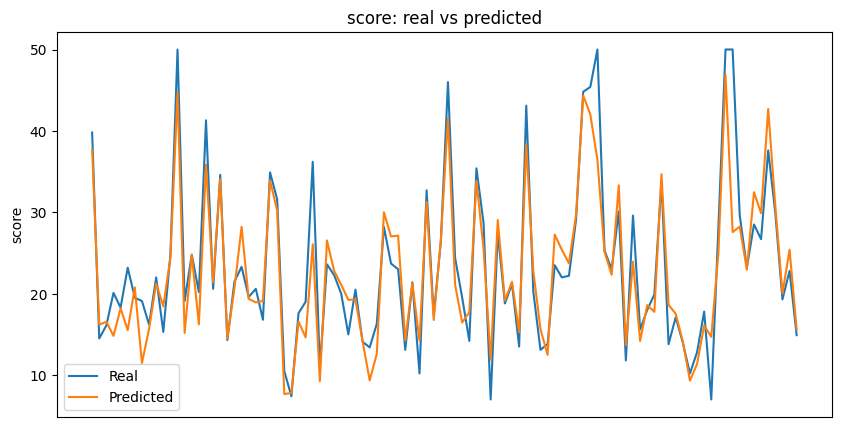

In [42]:
final_predictions=best.predict(X_test)
plot_predict(y_test,final_predictions)

In [37]:
DF_class=pd.DataFrame(results.cv_results_)

DF = DF_class[['param_model','mean_test_score', 'rank_test_score']]
cm = sns.light_palette("seagreen", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_model,mean_test_score,rank_test_score
28,Ridge(alpha=2.1544346900318834),-8.684568,1
26,Ridge(alpha=2.1544346900318834),-8.695887,2
24,Ridge(alpha=2.1544346900318834),-8.912430,3
30,Ridge(alpha=2.1544346900318834),-9.041908,4
22,Ridge(alpha=2.1544346900318834),-9.177962,5
20,Ridge(alpha=2.1544346900318834),-9.389230,6
32,Ridge(alpha=2.1544346900318834),-10.035943,7
34,Ridge(alpha=2.1544346900318834),-11.955915,8
0,Lasso(),-11.990463,9
36,Ridge(alpha=2.1544346900318834),-14.612650,10
